In [1]:
import duckdb
import os

# Connect to an in-memory DuckDB instance
con = duckdb.connect(database=':memory:')

sponsor_times = con.read_csv(
    "sb-mirror/sponsorTimes.csv",
    header=True,
    columns={
        "videoID": "VARCHAR",
        "startTime": "DOUBLE",
        "endTime": "DOUBLE",
        "votes": "INTEGER",
        "locked": "INTEGER",
        "incorrectVotes": "INTEGER",
        "UUID": "VARCHAR",
        "userID": "VARCHAR",
        "timeSubmitted": "DOUBLE",
        "views": "INTEGER",
        "category": "VARCHAR",
        "actionType": "VARCHAR",
        "service": "VARCHAR",
        "videoDuration": "DOUBLE",
        "hidden": "INTEGER",
        "reputation": "DOUBLE",
        "shadowHidden": "INTEGER",
        "hashedVideoID": "VARCHAR",
        "userAgent": "VARCHAR",
        "description": "VARCHAR",
    },
    ignore_errors=True,
    quotechar="",
)


video_info = con.read_csv(
    "sb-mirror/videoInfo.csv",
    header=True,
    columns={
        "videoID": "VARCHAR",
        "channelID": "VARCHAR",
        "title": "VARCHAR",
        "published": "DOUBLE",
    },
    ignore_errors=True,
    quotechar=None,
)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cont how many rows of sponsor and self promo there are with more than 0 votes, and less than 0 votes
con.sql("select count(*) filter (where votes > 0 or locked = 1) as more_than_0_votes, count(*) as total_segments from sponsor_times where category in ('sponsor', 'selfpromo')").show()

# Total = 5126136
# More than 0 = 668696
# Percentage reduction
100 - (668696 / 5126136) * 100


┌───────────────────┬────────────────┐
│ more_than_0_votes │ total_segments │
│       int64       │     int64      │
├───────────────────┼────────────────┤
│            738811 │        5126136 │
└───────────────────┴────────────────┘



86.95516466984098

# Building the Unique Ad dataset

More information about how I came into this conclusion to build the dataset at the end of exploration.ipynb notebook.

Summary, though:

- We're only interested in 'sponsor' and 'selfpromo' segments
- I'm only getting user-submission of ad segments that have MORE THAN ZERO VOTES.
- Doing this reduces heavily the dataset, but it also removes so many videos that are very random and have 99.99% ad time.
- After this, we kinda need to make sure we're not getting duplicate ad segments, the explanation for this is better done in the exploration notebook.



In [3]:
# Check if unique_ad_segments.parquet exists, if so, load it.
# If not, build it.
force_rebuild = True
if os.path.exists("sb-mirror/unique_ad_segments.parquet") and not force_rebuild:
    unique_segments = con.read_parquet("sb-mirror/unique_ad_segments.parquet")
else:
    # Flag distinct ad segments of the same video
    new_segments = con.sql("""
    SELECT
        COALESCE(startTime > LAG(endTime) OVER (PARTITION BY videoID ORDER BY startTime), true) AS new_ad_segment,
        *
    FROM sponsor_times
    WHERE category IN ('sponsor', 'selfpromo') AND (votes > 0 or locked = 1)
    """)

    # Number each ad segment for each video
    ad_segments = con.sql("""
    SELECT
        SUM(new_ad_segment) OVER (PARTITION BY videoID ORDER BY startTime) AS ad_segment,
        *
    FROM new_segments
    """)

    # Gets either the 'locked' ad segment or the one with the most votes
    export = con.sql("""
    SELECT DISTINCT ON (videoID, ad_segment)
        *
    FROM ad_segments
    ORDER BY videoID, ad_segment, locked DESC, votes DESC
    """)

    # Save it to a parquet file
    export.to_parquet("sb-mirror/unique_ad_segments.parquet")

    # Now let's load the parquet
    unique_segments = con.read_parquet("sb-mirror/unique_ad_segments.parquet")


In [4]:
# Finding a good example
con.sql("select videoID, startTime, endTime, locked, votes, ad_segment::integer as ad_segment  from unique_segments where videoID = '2Hc_QSM9DuY'")

┌─────────────┬───────────┬───────────┬────────┬───────┬────────────┐
│   videoID   │ startTime │  endTime  │ locked │ votes │ ad_segment │
│   varchar   │  double   │  double   │ int32  │ int32 │   int32    │
├─────────────┼───────────┼───────────┼────────┼───────┼────────────┤
│ 2Hc_QSM9DuY │ 24.547832 │ 42.047787 │      0 │    17 │          1 │
│ 2Hc_QSM9DuY │ 53.929913 │  66.49598 │      0 │    23 │          2 │
└─────────────┴───────────┴───────────┴────────┴───────┴────────────┘

# Answering Some Simple Questions

## How Many Channels do We Have Present?

In [5]:
# The ChannelID is only preset in the video_info, meaning we will have to join it with the unique_ad_segments
# to get the channelID and count. This is because we've filtered out sponsor/self promo only, so we really need the join
con.sql("select count(distinct channelID) as channel_count from unique_segments left join video_info on unique_segments.videoID = video_info.videoID").show()

┌───────────────┐
│ channel_count │
│     int64     │
├───────────────┤
│         36044 │
└───────────────┘



## How Many Videos Do We Have?

In [6]:
con.sql("select count(distinct videoID) as video_count from unique_segments").show()

┌─────────────┐
│ video_count │
│    int64    │
├─────────────┤
│      552597 │
└─────────────┘



## How Many Ad Segments We Have?

In [7]:
con.sql("select count(*) as ad_segment_count from unique_segments").show()

┌──────────────────┐
│ ad_segment_count │
│      int64       │
├──────────────────┤
│           673834 │
└──────────────────┘



In [8]:
# Total videos = 552597
# Ad Segments = 673835
# Avg Segments per Video:
673835 / 552597

1.21939677558872

## What is the name of the top 5 channels with the most videos?

In [9]:
top_5_channels = con.sql("""
    select
        channelID,
        count(distinct unique_segments.videoID) as video_count
    from unique_segments
    left join video_info on unique_segments.videoID = video_info.videoID
    -- Because of how we used the quoted strings, the empty channel string is '""'
    WHERE channelID is not null and channelID != '""'
    group by channelID
    order by video_count desc
    limit 5
""")

top_5_channels.show()

┌──────────────────────────┬─────────────┐
│        channelID         │ video_count │
│         varchar          │    int64    │
├──────────────────────────┼─────────────┤
│ UCXuqSBlHAE6Xw-yeJA0Tunw │        2260 │
│ UCfwE_ODI1YTbdjkzuSi1Nag │         946 │
│ UC4HCh2xl_d5MNNbcPe6hrfg │         829 │
│ UCsE_m2z1NrvF2ImeNWh84mw │         764 │
│ UChIs72whgZI9w6d6FhwGGHA │         698 │
└──────────────────────────┴─────────────┘



In [10]:
# Let's do something cool, let's import the API function and get the channel names, as it's not present in the dataset.
# WARNING: Do this only for a limited amount of channels, otherwise you will be charged for the API calls, probably.
from youtube_api import get_channel_name

# Try registering the function, ignore if already exists
try:
    con.create_function('get_channel_name', get_channel_name, [str], str)
except Exception as e:
    print(f"Skipping function registration (possibly already exists): {e}")

# Get the channel names
channel_names = con.sql("""
    select
        channelID,
        get_channel_name(channelID) as channel_name,
        video_count
    from top_5_channels
""")

channel_names.show()

┌──────────────────────────┬────────────────────────┬─────────────┐
│        channelID         │      channel_name      │ video_count │
│         varchar          │        varchar         │    int64    │
├──────────────────────────┼────────────────────────┼─────────────┤
│ UCXuqSBlHAE6Xw-yeJA0Tunw │ Linus Tech Tips        │        2260 │
│ UCfwE_ODI1YTbdjkzuSi1Nag │ TheQuartering          │         946 │
│ UC4HCh2xl_d5MNNbcPe6hrfg │ Майни                  │         829 │
│ UCsE_m2z1NrvF2ImeNWh84mw │ Active Self Protection │         764 │
│ UChIs72whgZI9w6d6FhwGGHA │ Gamers Nexus           │         698 │
└──────────────────────────┴────────────────────────┴─────────────┘



## How long are the videos, usually?

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

video_lengths = con.sql("""
  SELECT DISTINCT ON (videoID)
      videoID,
      videoDuration
  FROM
      unique_segments
  WHERE
      videoID IS NOT NULL
      AND videoDuration > 0
"""
).df()

# Get the relevant statistics, dividing by 60 to get minutes
stats = np.percentile(video_lengths["videoDuration"]/60, [0, 25, 50, 75, 100])
iqr = stats[3] - stats[1] 

# Print the boxplot statistics
print(f"Min: {stats[0]}")
print(f"Q1 (25%): {stats[1]}")
print(f"Median (50%): {stats[2]}")
print(f"Q3 (75%): {stats[3]}")
print(f"Max: {stats[4]}")
print(f"IQR: {iqr}")


Min: 0.07668333333333334
Q1 (25%): 10.846815
Median (50%): 16.154883333333334
Q3 (75%): 25.965016666666667
Max: 1348.7944
IQR: 15.118201666666668


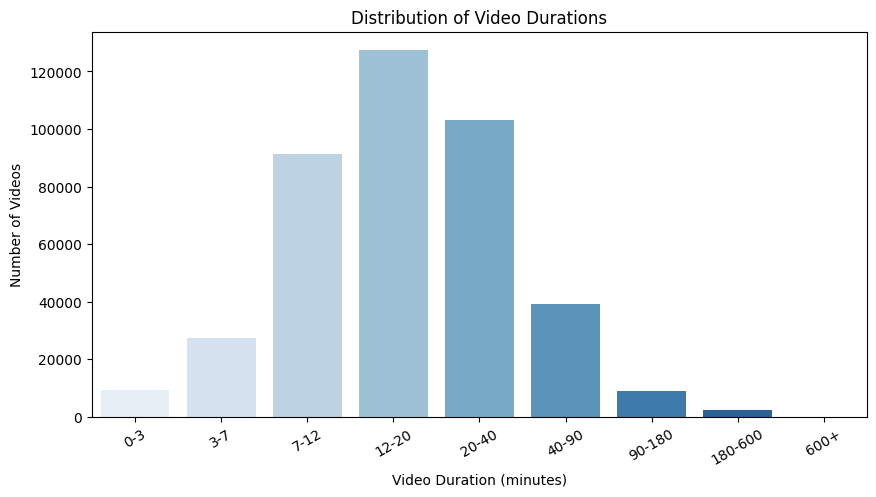

In [12]:
# Define custom bins, in minutes
bins = [0, 3, 7, 12, 20, 40, 90, 180, 600, 9999999] 
labels = ["0-3", "3-7", "7-12", "12-20", "20-40", "40-90", "90-180", "180-600", "600+"]

# Assign each video to a bucket
video_lengths["duration_bucket"] = pd.cut(video_lengths["videoDuration"] / 60, bins=bins, labels=labels, right=False)

# Count how many videos fall into each bucket
bucket_counts = video_lengths["duration_bucket"].value_counts().sort_index()

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=bucket_counts.index, y=bucket_counts.values, palette="Blues")

plt.xlabel("Video Duration (minutes)")
plt.ylabel("Number of Videos")
plt.title("Distribution of Video Durations")
plt.xticks(rotation=30)
plt.show()

# This makes sense, so many videos around 7-20minutes, which matches my personal experience. Was surpised though with the amount of videos after 20 minutes,
# but from exploring these data, a lot of it are probably livestreams, because it makes sense for them to be 30min+

## What percentage of those videos are ads? Broken down by the same buckets as above.

- Only for videos < 90min

In [13]:
video_total_ads = con.sql("""
    select
        videoID,
        videoDuration,
        SUM(endTime - startTime) as total_ad_duration
    from unique_segments
    where videoDuration < 5400
    group by videoID, videoDuration
""")

# Quickly check if this doesn't have repeated videoIDs, just to make sure the videoDuration for every video id is always the same
con.sql("select count(distinct videoID) as unique_videos, count(*) as total_videos from video_total_ads").show()

# Ugh... Okay, we need to figure this out, let's get some repeated ids:
con.sql("select videoID, count(*) as count from video_total_ads group by videoID order by count(*) desc limit 10").show()


┌───────────────┬──────────────┐
│ unique_videos │ total_videos │
│     int64     │    int64     │
├───────────────┼──────────────┤
│        541180 │       553640 │
└───────────────┴──────────────┘

┌─────────────┬───────┐
│   videoID   │ count │
│   varchar   │ int64 │
├─────────────┼───────┤
│ 9_6MA0IACi0 │     8 │
│ UQMB7LiVjEQ │     6 │
│ SCvhHAxXvx4 │     5 │
│ rsr8S7HluEY │     5 │
│ -WJxhQBbUVI │     5 │
│ qw-6761qH6U │     5 │
│ pC6MCPPoHI8 │     5 │
│ b0gkLtNsGKI │     5 │
│ mXGE8Pn8ADE │     5 │
│ cyc7D220tfA │     4 │
├─────────────┴───────┤
│ 10 rows   2 columns │
└─────────────────────┘



In [14]:
# chrOu6ic6XM, dqPomYO_8Pg, uQcd7bqzYAA

# Let's filter for those and try to understand what's going on:
con.sql("select * from unique_segments where videoID in ('chrOu6ic6XM', 'dqPomYO_8Pg', 'uQcd7bqzYAA')").show()

┌────────────┬────────────────┬─────────────┬───────────┬───────────┬───────┬────────┬────────────────┬───────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────┬─────────────────┬───────┬──────────┬────────────┬─────────┬───────────────┬────────┬────────────┬──────────────┬──────────────────────────────────────────────────────────────────┬───────────────────────────────────────┬─────────────┐
│ ad_segment │ new_ad_segment │   videoID   │ startTime │  endTime  │ votes │ locked │ incorrectVotes │                               UUID                                │                              userID                              │  timeSubmitted  │ views │ category │ actionType │ service │ videoDuration │ hidden │ reputation │ shadowHidden │                          hashedVideoID                           │               userAgent               │ description │
│   double   │    boolean     │   varchar   │  double 

In [15]:
# Meh, there are some differences, but let's then just get always the MAX duration for each videoID:
video_total_ads = con.sql(
    """
    select
        videoID,
        MAX(videoDuration) as videoDuration,
        SUM(endTime - startTime) as total_ad_duration,
        SUM(endTime - startTime) / 60 as ad_minutes,
        SUM(endTime - startTime) / MAX(videoDuration) as ad_percentage,
        MAX(videoDuration) / 60 as video_duration_minutes
    from unique_segments
    where videoDuration > 0
        and videoDuration < 5400
        and videoID is not null
    group by videoID
"""
)

con.sql("select * from video_total_ads LIMIT 10").show()

┌─────────────┬───────────────┬────────────────────┬─────────────────────┬──────────────────────┬────────────────────────┐
│   videoID   │ videoDuration │ total_ad_duration  │     ad_minutes      │    ad_percentage     │ video_duration_minutes │
│   varchar   │    double     │       double       │       double        │        double        │         double         │
├─────────────┼───────────────┼────────────────────┼─────────────────────┼──────────────────────┼────────────────────────┤
│ uL9cTfEe288 │         516.0 │             35.571 │             0.59285 │  0.06893604651162791 │                    8.6 │
│ uLF8C19dBxQ │         705.0 │ 28.194360000000003 │ 0.46990600000000005 │  0.03999200000000001 │                  11.75 │
│ uLH3qeL3VgU │       481.021 │ 24.551000000000002 │ 0.40918333333333334 │  0.05103935171229531 │      8.017016666666667 │
│ uLX46FIETII │        2003.0 │             17.662 │ 0.29436666666666667 │ 0.008817773339990015 │      33.38333333333333 │
│ uLlOZV9Ne1o │ 

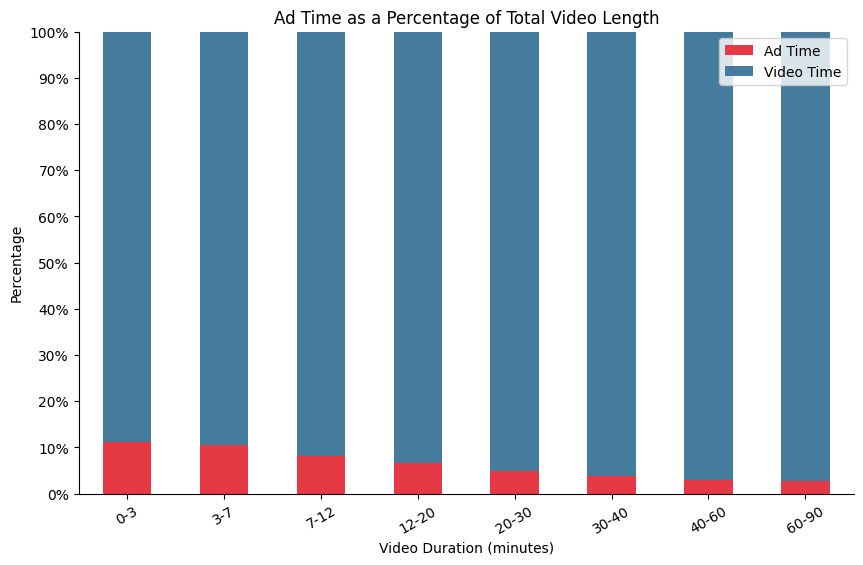

In [16]:
# Define duration buckets (in minutes)
bins = [0, 3, 7, 12, 20, 30, 40, 60, 90]    
labels = ["0-3", "3-7", "7-12", "12-20", "20-30", "30-40", "40-60", "60-90"]

# Okay let's do this in Pandas as it's a builtin thing
video_total_ads = video_total_ads.df()

# Assign videos to buckets
video_total_ads["duration_bucket"] = pd.cut(video_total_ads["videoDuration"] / 60, bins=bins, labels=labels, right=False)

# Group by bucket and sum ad times and total durations
bucket_data = video_total_ads.groupby("duration_bucket")[["ad_minutes", "videoDuration"]].sum()

# Convert to percentage of total video time
bucket_data["ad_percentage"] = (bucket_data["ad_minutes"] / (bucket_data["videoDuration"] / 60)) * 100
bucket_data["video_percentage"] = 100 - bucket_data["ad_percentage"]

# Plot 100% stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bucket_data[["ad_percentage", "video_percentage"]].plot(
    kind="bar", stacked=True, color=["#E63946", "#457B9D"], ax=ax
)

plt.xlabel("Video Duration (minutes)")
plt.ylabel("Percentage")
plt.title("Ad Time as a Percentage of Total Video Length")
plt.legend(["Ad Time", "Video Time"])
plt.xticks(rotation=30)
plt.ylim(0, 100)

ax.set_yticks(range(0, 101, 10))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}%"))

sns.despine()

plt.show()

In [17]:
print(bucket_data)

                    ad_minutes  videoDuration  ad_percentage  video_percentage
duration_bucket                                                               
0-3                1722.653520   9.290686e+05      11.125036         88.874964
3-7               14819.448798   8.543040e+06      10.408086         89.591914
7-12              72983.927832   5.365736e+07       8.161109         91.838891
12-20            129799.778370   1.189349e+08       6.548109         93.451891
20-30             85401.312405   1.063319e+08       4.818947         95.181053
30-40             38248.018255   6.193170e+07       3.705503         96.294497
40-60             36354.326787   7.284312e+07       2.994462         97.005538
60-90             26895.190264   6.110589e+07       2.640844         97.359156


## Has the percentage of ads changed during the years?

We actually haven't played around with the published dates yet, so let's do that now.

In [18]:
# Let's join the channel info, sticking with the same datasetet as before
video_total_ads = con.sql("select * from video_total_ads left join video_info on video_total_ads.videoID = video_info.videoID")

video_total_ads.show()

┌─────────────┬───────────────┬────────────────────┬─────────────────────┬──────────────────────┬────────────────────────┬─────────────────────────────────────────────────────────────────────────┬─────────────┬──────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────┐
│   videoID   │ videoDuration │ total_ad_duration  │     ad_minutes      │    ad_percentage     │ video_duration_minutes │                             duration_bucket                             │   videoID   │        channelID         │                                                title                                                │  published   │
│   varchar   │    double     │       double       │       double        │        double        │         double         │ enum('0-3', '3-7', '7-12', '12-20', '20-30', '30-40', '40-60', '60-90') │   varchar   │         varchar          │                                               varcha

In [19]:
# Wait, seems to be some mussing "published" dates. Let's check how many
con.sql("select count(*) filter (where published is null or published < 1) as missing_published, count(*) as total_videos from video_info").show()

# Also show 10 lines where it matches those filters
con.sql("select * from video_info where published is null or published < 1 limit 10").show()

# Are there actually null valuees or only zeros?
con.sql("select count(*) filter (where published is null) as null_published, count(*) filter (where published = 0) as zero_published from video_info").show()

┌───────────────────┬──────────────┐
│ missing_published │ total_videos │
│       int64       │    int64     │
├───────────────────┼──────────────┤
│           5409377 │      8499191 │
└───────────────────┴──────────────┘

┌─────────────┬───────────┬─────────┬───────────┐
│   videoID   │ channelID │  title  │ published │
│   varchar   │  varchar  │ varchar │  double   │
├─────────────┼───────────┼─────────┼───────────┤
│ VGcxigAoryY │ NULL      │ NULL    │       0.0 │
│ TAbAzHj46ew │ NULL      │ NULL    │       0.0 │
│ RFudGy_JHYY │ NULL      │ NULL    │       0.0 │
│ GW8mlub9SS4 │ NULL      │ NULL    │       0.0 │
│ 1DsMEWI6ig4 │ NULL      │ NULL    │       0.0 │
│ ugt_p6-NDD4 │ NULL      │ NULL    │       0.0 │
│ ysSjTpEaWQc │ NULL      │ NULL    │       0.0 │
│ seTgViqk9tA │ NULL      │ NULL    │       0.0 │
│ E0lRKpF4tkQ │ NULL      │ NULL    │       0.0 │
│ 6S6h8Irjuj8 │ NULL      │ NULL    │       0.0 │
├─────────────┴───────────┴─────────┴───────────┤
│ 10 rows                  

In [20]:
# Select published where is > 0
video_total_ads = con.sql("""
    SELECT 
        *,
        to_timestamp(NULLIF(published, 0)) as published_date,
        extract(year from to_timestamp(NULLIF(published, 0))) as published_year 
    FROM video_total_ads
""")

In [21]:
# Ok, so with that, we lost a lot of videos, actually, reducing our dataset like crazy,
# Let's just get a table of amount of videos per year.
con.sql("select published_year, count(distinct videoID) as video_count from video_total_ads group by published_year order by published_year").show()

┌────────────────┬─────────────┐
│ published_year │ video_count │
│     int64      │    int64    │
├────────────────┼─────────────┤
│           2007 │           4 │
│           2008 │           1 │
│           2009 │          12 │
│           2010 │          19 │
│           2011 │          21 │
│           2012 │          32 │
│           2013 │          73 │
│           2014 │         107 │
│           2015 │         196 │
│           2016 │         275 │
│           2017 │         491 │
│           2018 │         805 │
│           2019 │        1385 │
│           2020 │        2366 │
│           2021 │       33336 │
│           2022 │       60548 │
│           2023 │        2645 │
│           2024 │         366 │
│           NULL │      294876 │
├────────────────┴─────────────┤
│ 19 rows            2 columns │
└──────────────────────────────┘



In [22]:
# That's crazy that we don't have that many videos in 2024?! Let's just check this agian but from the video_info table, grouping by year
con.sql("select extract(year from to_timestamp(published)) as published_year, count(distinct videoID) as video_count from video_info group by published_year order by published_year").show()

# THat is kinda crazy.
# Let me just see if I actually read all the lines correctly from the video_info table
con.sql("select count(*) from video_info").show()


┌────────────────┬─────────────┐
│ published_year │ video_count │
│     int64      │    int64    │
├────────────────┼─────────────┤
│           1970 │     5409376 │
│           2005 │           9 │
│           2006 │         263 │
│           2007 │        2378 │
│           2008 │        4893 │
│           2009 │        8898 │
│           2010 │       12717 │
│           2011 │       19434 │
│           2012 │       32183 │
│           2013 │       47053 │
│           2014 │       48452 │
│           2015 │       59435 │
│           2016 │       78111 │
│           2017 │       96369 │
│           2018 │      124400 │
│           2019 │      164574 │
│           2020 │      239463 │
│           2021 │      584460 │
│           2022 │     1531168 │
│           2023 │       30739 │
│           2024 │        4815 │
├────────────────┴─────────────┤
│ 21 rows            2 columns │
└──────────────────────────────┘

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      

In [23]:
!wc -l sb-mirror/videoInfo.csv

 8499517 sb-mirror/videoInfo.csv


In [24]:
# Hmm, this still doesn't sit right with me. I've noticed that "published" info are really stored as "1.6344288e+09" in the CSV.
# Let me get some random rows with timestamps
# EXAMPLES
# 4S7g3XY4jeM,UCK7tptUDHh-RYDsdxO1-5QQ,Faces of Alzheimer's: How Communities Help,1.4455584e+09
# r4_NZtllKOY,UC3TbT_taTdB5_pxcHnNNHAg,Social Science Sunday: Example Qualitative Case Studiy,1.6616448e+09
# nthImXK34l4,UCOhHO2ICt0ti9KAh-QHvttQ,Google Pixel 4 Unboxing & First Look | RADAR + Crazy Camera | Pizza Edition🔥🔥🔥,1.5712704e+09
# K-0mYyAp_2I,UCGySEZYkh1lvOaMdQr9QtrA,Driver easy pro crack \ Free download 2022 \ Crack 2022,1.664064e+09
# w-2feEVmWjI,UCsMica-v34Irf9KVTh6xx-g,Azure IoT Edge development with Azure DevOps,1.5607296e+09

# Now get them manually here on sql
con.sql("select *, to_timestamp(published) as published_timestamp from video_info where videoID in ('4S7g3XY4jeM', 'r4_NZtllKOY', 'nthImXK34l4', 'K-0mYyAp_2I', 'w-2feEVmWjI')").show()

# Checked the ones availalbe, seems correct.
# I guess we just don't have video info for 2024?! This is very odd. The dataset should be very up to date.
# And we don't have any video for 2025.
# So maybe they just stopped collecting this data? Idk.
# Still, I will work with what I have.

┌─────────────┬──────────────────────────┬───────────────────────────────────────────────────────────────────────────────────┬──────────────┬──────────────────────────┐
│   videoID   │        channelID         │                                       title                                       │  published   │   published_timestamp    │
│   varchar   │         varchar          │                                      varchar                                      │    double    │ timestamp with time zone │
├─────────────┼──────────────────────────┼───────────────────────────────────────────────────────────────────────────────────┼──────────────┼──────────────────────────┤
│ 4S7g3XY4jeM │ UCK7tptUDHh-RYDsdxO1-5QQ │ Faces of Alzheimer's: How Communities Help                                        │ 1445558400.0 │ 2015-10-23 01:00:00+01   │
│ r4_NZtllKOY │ UC3TbT_taTdB5_pxcHnNNHAg │ Social Science Sunday: Example Qualitative Case Studiy                            │ 1661644800.0 │ 2022-08-28 01

In [25]:
video_total_ads = con.sql("select * from video_total_ads")
video_total_ads

┌─────────────┬───────────────┬────────────────────┬─────────────────────┬──────────────────────┬────────────────────────┬─────────────────────────────────────────────────────────────────────────┬─────────────┬──────────────────────────┬────────────────────────────────────────────────────────────────────────────┬──────────────┬──────────────────────────┬────────────────┐
│   videoID   │ videoDuration │ total_ad_duration  │     ad_minutes      │    ad_percentage     │ video_duration_minutes │                             duration_bucket                             │  videoID_1  │        channelID         │                                   title                                    │  published   │      published_date      │ published_year │
│   varchar   │    double     │       double       │       double        │        double        │         double         │ enum('0-3', '3-7', '7-12', '12-20', '20-30', '30-40', '40-60', '60-90') │   varchar   │         varchar          │               

In [26]:
# Limiting the years as for these here I have a "decent" amount of data.
start_year = 2018
end_year = 2023

plot_df = (
    video_total_ads.df()
    .query(f"published_year >= {start_year} and published_year <= {end_year}")
    .groupby(["published_year", "duration_bucket"], as_index=False)
    [["ad_minutes", "video_duration_minutes"]]
    .sum()
)

# Calculate ad_percentage & content_percentage
plot_df["ad_percentage"] = (
    plot_df["ad_minutes"] / plot_df["video_duration_minutes"] * 100
)
plot_df["content_percentage"] = 100 - plot_df["ad_percentage"]


video_counts = (
    video_total_ads.df()
    .query(f"published_year >= {start_year} and published_year <= {end_year}")
    .groupby("published_year", as_index=False)
    .size()
    .rename(columns={"size": "n_videos"})
)


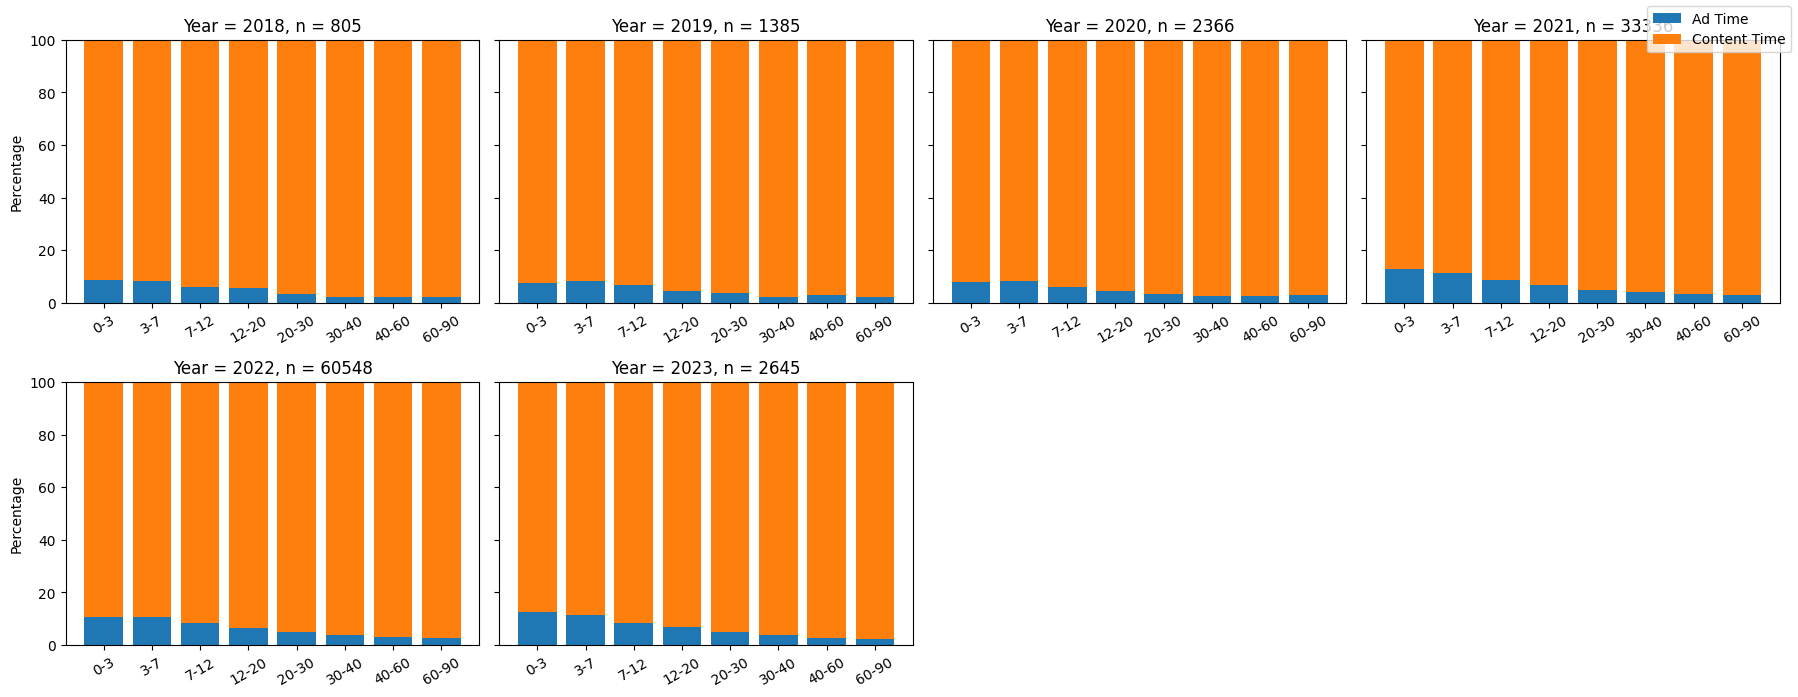

In [27]:
import matplotlib.pyplot as plt

all_years = sorted(plot_df["published_year"].unique())

nrows, ncols = 3, 4  # enough subplots for up to 12 years
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10), sharey=True)
axes = axes.flatten()

for i, year in enumerate(all_years):
    ax = axes[i]
    subset = plot_df[plot_df["published_year"] == year].copy()
    subset = subset.sort_values("duration_bucket")

    # Get the total number of videos for this year
    n_videos = video_counts.loc[video_counts["published_year"] == year, "n_videos"].iloc[0]

    x = subset["duration_bucket"]
    ad_p = subset["ad_percentage"]
    content_p = subset["content_percentage"]

    # 100% stacked bars
    ax.bar(x, ad_p, label="Ad Time")
    ax.bar(x, content_p, bottom=ad_p, label="Content Time")

    # Subplot title includes the year and the n_videos
    ax.set_title(f"Year = {year}, n = {n_videos}")

    ax.set_ylim(0, 100)
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(x, rotation=30)
    if i % ncols == 0:
        ax.set_ylabel("Percentage")

# Remove extra (blank) subplots if we have fewer years than nrows*ncols
for j in range(i+1, nrows*ncols):
    fig.delaxes(axes[j])

# Single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.tight_layout()
plt.show()


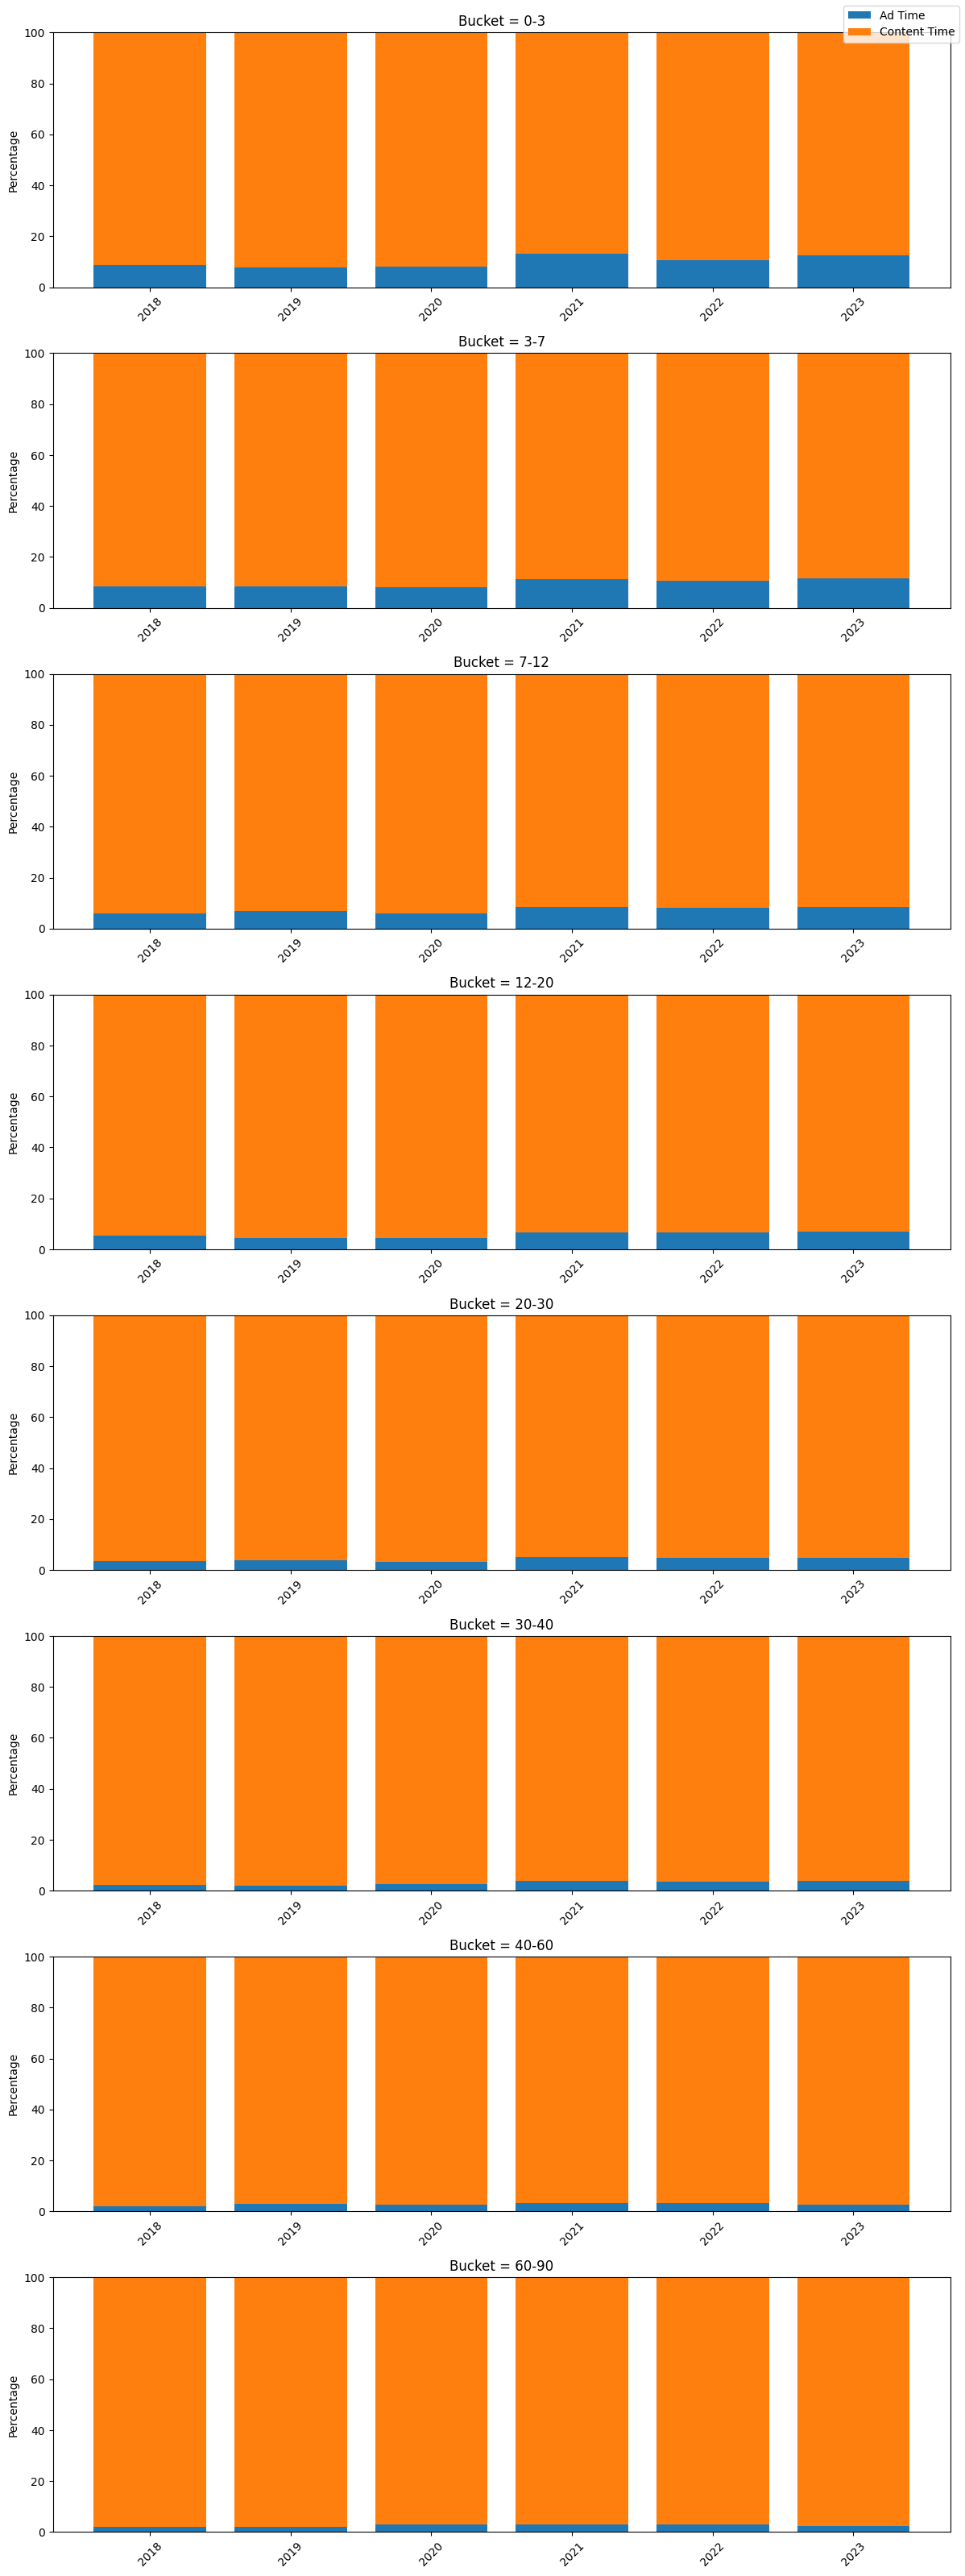

In [28]:
bucket_order = ["0-3", "3-7", "7-12", "12-20", "20-30", "30-40", "40-60", "60-90"]
# Filter the above to only include what's actually present in plot_df
available_buckets = plot_df["duration_bucket"].unique().tolist()
ordered_buckets = [b for b in bucket_order if b in available_buckets]

fig, axes = plt.subplots(nrows=len(ordered_buckets), figsize=(12, 4 * len(ordered_buckets)), sharey=True)

for i, bucket in enumerate(ordered_buckets):
    ax = axes[i]
    subset = plot_df[plot_df["duration_bucket"] == bucket].copy()
    subset = subset.sort_values("published_year")

    x = subset["published_year"]
    ad_p = subset["ad_percentage"]
    content_p = subset["content_percentage"]

    ax.bar(x, ad_p, label="Ad Time")
    ax.bar(x, content_p, bottom=ad_p, label="Content Time")

    ax.set_title(f"Bucket = {bucket}")
    ax.set_ylim(0, 100)
    ax.set_xticks(x)
    ax.set_xticklabels(x, rotation=45)
    ax.set_ylabel("Percentage")

# Single legend for all subplots (just use the first one’s handles)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.tight_layout()
plt.show()


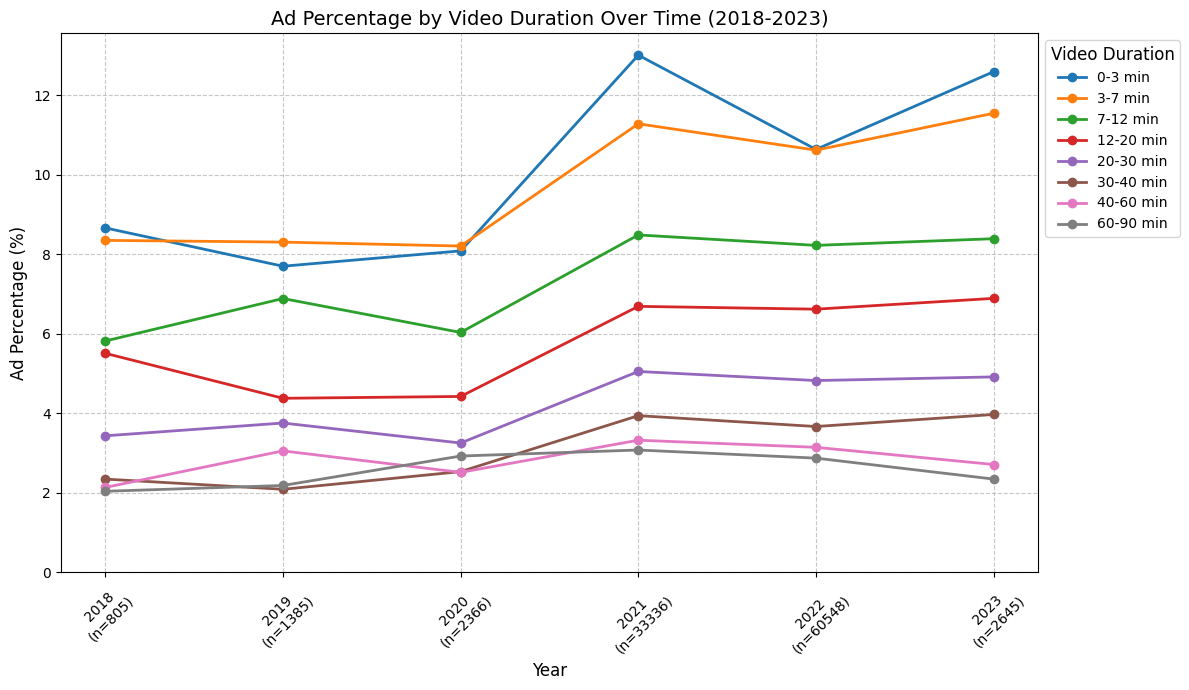

In [29]:
# Define bucket order and filter to available buckets
bucket_order = ["0-3", "3-7", "7-12", "12-20", "20-30", "30-40", "40-60", "60-90"]
available_buckets = plot_df["duration_bucket"].unique().tolist()
ordered_buckets = [b for b in bucket_order if b in available_buckets]

# Create a single line chart
fig, ax = plt.subplots(figsize=(12, 7))

colors = plt.cm.tab10(np.arange(len(ordered_buckets)))

# Plot each bucket as a separate line
for i, bucket in enumerate(ordered_buckets):
    subset = plot_df[plot_df["duration_bucket"] == bucket].copy()
    subset = subset.sort_values("published_year")
    
    # Plot the line
    ax.plot(
        subset["published_year"], 
        subset["ad_percentage"], 
        marker='o', 
        linewidth=2, 
        label=f"{bucket} min", 
        color=colors[i]
    )

# Create dictionary to map years to counts for easier lookup
year_to_count = dict(zip(video_counts["published_year"], video_counts["n_videos"]))

# Add title and labels
ax.set_title(f"Ad Percentage by Video Duration Over Time ({start_year}-{end_year})", fontsize=14)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Ad Percentage (%)", fontsize=12)

# Set x-ticks with video counts
years = sorted(plot_df["published_year"].unique())
ax.set_xticks(years)
ax.set_xticklabels([f"{year}\n(n={year_to_count[year]})" for year in years], rotation=45)

ax.grid(True, linestyle='--', alpha=0.7)

# Set y-axis to start from 0
ax.set_ylim(bottom=0)

# Add legend with good positioning
ax.legend(title="Video Duration", title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

## Which Channel has the highest ad percentage?

In [30]:
# # Let's join the channel info
# video_total_ads = con.sql("select * from video_total_ads left join video_info on video_total_ads.videoID = video_info.videoID")


In [31]:
# Lets join the channel info
video_total_ads = con.sql("select * from video_total_ads left join video_info on video_total_ads.videoID = video_info.videoID")

# Let's now get the ad percentage per channel
ad_percentage_per_channel = con.sql("select channelID, sum(ad_minutes) as channel_total_ad_minutes, sum(videoDuration) / 60 as channel_total_video_minutes from video_total_ads group by channelID").df()

# Now let's calculate the ad percentage
ad_percentage_per_channel["channel_ad_percentage"] = (ad_percentage_per_channel["channel_total_ad_minutes"] / ad_percentage_per_channel["channel_total_video_minutes"]) * 100

# Let's plot the top 10
con.sql("""
    select
        channelID,
        channel_total_video_minutes,
        channel_total_ad_minutes,
        channel_ad_percentage
    from ad_percentage_per_channel
    order by channel_ad_percentage desc
    limit 10
""").show()


┌──────────────────────────┬─────────────────────────────┬──────────────────────────┬───────────────────────┐
│        channelID         │ channel_total_video_minutes │ channel_total_ad_minutes │ channel_ad_percentage │
│         varchar          │           double            │          double          │        double         │
├──────────────────────────┼─────────────────────────────┼──────────────────────────┼───────────────────────┤
│ UC2hhiaW_AhsNi3760H8coWA │                     4.58135 │        4.417683333333334 │     96.42754501038632 │
│ UCSKQMdnWQSZyzD14oILr7pg │           9.931016666666666 │        8.271216666666668 │     83.28670612777142 │
│ UCRfKAOIvCqTKZF3wy3Jr-BQ │                     2.84055 │       2.2611833333333333 │     79.60371524294004 │
│ UCZhkUguiTBJVZrrdMSjLbsQ │          3.2333333333333334 │                  2.56695 │       79.390206185567 │
│ UC1F6Vh7iRLSjPks3Xr8GjJA │          14.733333333333333 │                 11.65915 │     79.13450226244343 │
│ UCmEj0yP

In [32]:
# Okay, it seems that above 30min is a good cutoff, so let's do that again, to find the top channels that
# have at least 30min of video time. Which ones have the most ad percentage?
# Also I'm getting more than 50 channels because some of them end up not having a name.
top_50_most_ads_channels = con.sql("""
    select
        channelID,
        channel_total_video_minutes,
        channel_total_ad_minutes,
        channel_ad_percentage
    from ad_percentage_per_channel
    where channel_total_video_minutes > 1800
        and channelID is not null
    order by channel_ad_percentage desc
    limit 60
""")

# Register the channel country and thumbnail functions
from youtube_api import get_channel_country, get_channel_small_thumbnail

try:
    con.create_function('get_channel_country', get_channel_country, [str], str)
except Exception as e:
    print(f"Skipping function registration (possibly already exists): {e}")

try:
    con.create_function('get_channel_small_thumbnail', get_channel_small_thumbnail, [str], str) 
except Exception as e:
    print(f"Skipping function registration (possibly already exists): {e}")



# Now let's get the channel names only on the top 50
top_50_most_ads_channels = con.sql("""
    SELECT
        *,
        get_channel_name(channelID) AS channel_name,
        get_channel_country(channelID) AS channel_country,
        get_channel_small_thumbnail(channelID) AS channel_thumbnail
    FROM top_50_most_ads_channels
""")

# Print it as as total_video_hours, total_ad_hours, ad percentage (in percentage)
# and also max 2 decimal points
con.sql("""
    select
        ROW_NUMBER() OVER (ORDER BY channel_ad_percentage DESC) as rank,
        channel_name,
        channel_country,
        ROUND(channel_total_video_minutes / 60, 2) as total_video_hours,
        ROUND(channel_total_ad_minutes / 60, 2) as total_ad_hours,
        ROUND(channel_ad_percentage, 2) || '%' as ad_percentage
    from top_50_most_ads_channels
    where channel_name is not null and channel_name != ''
    limit 50
""").show(max_rows=50)
# Export to
# .df().to_clipboard(sep='\t', index=False)



┌───────┬─────────────────────────────┬─────────────────┬───────────────────┬────────────────┬───────────────┐
│ rank  │        channel_name         │ channel_country │ total_video_hours │ total_ad_hours │ ad_percentage │
│ int64 │           varchar           │     varchar     │      double       │     double     │    varchar    │
├───────┼─────────────────────────────┼─────────────────┼───────────────────┼────────────────┼───────────────┤
│     1 │ Навигатор игрового мира     │ RU              │             51.64 │           7.39 │ 14.31%        │
│     2 │ 이동형TV                    │ KR              │              30.8 │           3.99 │ 12.95%        │
│     3 │ Dưa Leo                     │ VN              │             31.01 │           4.01 │ 12.92%        │
│     4 │ Jake Tran                   │ US              │             60.21 │           7.62 │ 12.66%        │
│     5 │ 강성범tv                    │ KR              │             32.11 │           3.93 │ 12.23%        │
│     6

In [33]:
con.sql("select * from top_50_most_ads_channels").show(max_rows=60)

┌──────────────────────────┬─────────────────────────────┬──────────────────────────┬───────────────────────┬─────────────────────────────┬─────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│        channelID         │ channel_total_video_minutes │ channel_total_ad_minutes │ channel_ad_percentage │        channel_name         │ channel_country │                                                      channel_thumbnail                                                      │
│         varchar          │           double            │          double          │        double         │           varchar           │     varchar     │                                                           varchar                                                           │
├──────────────────────────┼─────────────────────────────┼──────────────────────────┼───────────────────────┼─────────────────────────────┼─────────

In [34]:
top_50_most_ads_channels = top_50_most_ads_channels.df()

In [35]:
# Let's many the data prettier.
# First, some image for a channel I can't get, not sure why, it gets Forbidden access,
# So when channel id = UCfk5MMR4k6ulPmvvzkGe5kg, I will manually set this image
# https://yt3.googleusercontent.com/mv2KPHxh-LJhTxVLEsJYQbIVv4oOwiFB-hvzE2acF9WK8Jqw-C2NKDzWG8Q1VzUPA8Q594fu=s160-c-k-c0x00ffffff-no-rj

top_50_most_ads_channels.loc[top_50_most_ads_channels.channelID == "UCfk5MMR4k6ulPmvvzkGe5kg", "channel_thumbnail"] = "https://yt3.googleusercontent.com/mv2KPHxh-LJhTxVLEsJYQbIVv4oOwiFB-hvzE2acF9WK8Jqw-C2NKDzWG8Q1VzUPA8Q594fu=s160-c-k-c0x00ffffff-no-rj"


# Now, let's create an emoji map
country_to_flag = {
    # Countries from your data
    'RU': '🇷🇺',  # Russia
    'KR': '🇰🇷',  # South Korea
    'LV': '🇱🇻',  # Latvia
    'US': '🇺🇸',  # United States
    'DE': '🇩🇪',  # Germany
    'BR': '🇧🇷',  # Brazil
    'GB': '🇬🇧',  # United Kingdom
    'RS': '🇷🇸',  # Serbia
    'FR': '🇫🇷',  # France
    'IN': '🇮🇳',  # India
    'HK': '🇭🇰',  # Hong Kong
    'IL': '🇮🇱',  # Israel
    'SI': '🇸🇮',  # Slovenia
    'IT': '🇮🇹',  # Italy
    'CA': '🇨🇦',  # Canada
    '': '❓',      # Question mark for unknown
    None: '❓',    # Also for None/NULL
    'ES': '🇪🇸',  # Spain
    'JP': '🇯🇵',  # Japan
    'AU': '🇦🇺',  # Australia
    'NZ': '🇳🇿',  # New Zealand
    'MX': '🇲🇽',  # Mexico
    'CN': '🇨🇳',  # China
    'UA': '🇺🇦',  # Ukraine
    'SE': '🇸🇪',  # Sweden
    'NO': '🇳🇴',  # Norway
    'FI': '🇫🇮',  # Finland
    'DK': '🇩🇰',  # Denmark
    'PL': '🇵🇱',  # Poland
    'TR': '🇹🇷',  # Turkey
    'ZA': '🇿🇦',  # South Africa
    'AE': '🇦🇪',  # United Arab Emirates
    'SG': '🇸🇬',  # Singapore
}

# Map it
top_50_most_ads_channels["channel_country_flag"] = top_50_most_ads_channels["channel_country"].map(country_to_flag).fillna('❓')



In [ ]:
from IPython.display import HTML, display

df = con.sql("""
    select
        ROW_NUMBER() OVER (ORDER BY channel_ad_percentage DESC) as rank,
        channel_name || ' ' || channel_country_flag as channel_name,
        channel_country,
        channel_thumbnail,
        ROUND(channel_ad_percentage, 2) as ad_percentage
    from top_50_most_ads_channels
    where channel_name is not null and channel_name != ''
    limit 50
""").df()

df['ad_percentage'] = df['ad_percentage'].apply(lambda x: f"{x:.2f}%")

def format_thumbnail(thumbnail_url):
    return f'<div style="display: flex; justify-content: center; align-items: center; height: 100%;"><img src="{thumbnail_url}" width="60" height="60" style="border-radius: 50%; object-fit: cover;"></div>'

df = df[['rank', 'channel_thumbnail', 'channel_name', 'ad_percentage']]

df.columns = ['Rank', 'Channel Image', 'Channel', 'Ad Percentage']

html = df.to_html(escape=False, formatters={'Channel Image': format_thumbnail}, index=False)

html = f"""
<style>
    table {{
        border-collapse: collapse;
        width: 100%;
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        box-shadow: 0 4px 8px rgba(0,0,0,0.1);
        border-radius: 8px;
        overflow: hidden;
    }}
    th {{
        background-color: rgb(53, 104, 84);
        color: white;
        text-align: left;
        padding: 16px;
        font-weight: 600;
        text-transform: uppercase;
        font-size: 14px;
    }}
    td {{
        padding: 12px 16px;
        vertical-align: middle;
    }}
    tr:nth-child(even) {{
        background-color: #f8f9fa;
    }}
    tr:hover {{
        background-color: #e9f5fd;
    }}
    tr td:first-child {{
        font-weight: bold;
        text-align: center;
    }}
    tr td:nth-child(3) {{
        font-weight: 500;
    }}
    tr td:last-child {{
        font-weight: bold;
        color: black;
        text-align: right;
    }}
    .channel-image {{
        text-align: center;
    }}
    caption {{
        caption-side: top;
        padding: 10px;
        font-weight: bold;
        font-size: 1.2em;
    }}
</style>
<table class="table">
<caption>Top 50 YouTube Channels by Highest Ad Percentage</caption>
{html[html.find('<thead>'):]}
"""

with open('top_youtube_channels.html', 'w') as f:
    f.write(html)

# Display in Jupyter notebook
# display(HTML(html))

## At which point of the video do ADs usually happen?

This one I have two strategies:

1. Line Sweep --> Where we build the intervals kinda as an "event-based", and we can know how many videos are having ads at specific times during the video.
   - This is harder to understand, but should be easier to build in SQL. Also, it won't be perfectly implemented, but probably clsoe enough.
2. Binning --> Where we create bucket with specific resolutions for "percentage segment" and find how many ads were running in each segment
   - Easier to reason about it, I think this is a nightmare to build

In [37]:
# Filter out videos with invalid durations and excessively long durations
unique_segments_filtered = con.sql("""
    SELECT
        *
    FROM unique_segments
    WHERE videoID IS NOT NULL 
      AND videoDuration > 0 
      AND videoDuration < 144000
""")

In [38]:
# Getting a image for the blog post
con.sql("select videoID, startTime, endTime FROM unique_segments_filtered WHERE videoID NOT ilike '%-%' ORDER BY RANDOM ()LIMIT 10 ")

┌─────────────┬───────────┬──────────┐
│   videoID   │ startTime │ endTime  │
│   varchar   │  double   │  double  │
├─────────────┼───────────┼──────────┤
│ _FF4HSPoCwI │  1339.931 │ 1380.434 │
│ vkWiYyVGb6M │    42.972 │   84.425 │
│ HfEhwzi3C6Q │    41.488 │   130.33 │
│ NMYh7Y9TLtI │     370.0 │    488.0 │
│ hPJBPNwQFNU │   295.544 │  368.719 │
│ Ml7ycoLumAs │  1407.162 │ 1623.101 │
│ TpR1RoWM6YQ │       0.0 │   55.493 │
│ jOMVlSX6wPw │  0.569901 │ 37.60547 │
│ T_E7gLMH0L0 │     9.526 │   28.134 │
│ gKwDYiSx2zI │       0.0 │   59.033 │
├─────────────┴───────────┴──────────┤
│ 10 rows                  3 columns │
└────────────────────────────────────┘

In [39]:
# Let's do the line sweep and see if it's doable.
ad_intervals = con.sql("SELECT videoID, startTime, endTime, videoDuration FROM unique_segments_filtered WHERE videoDuration > 0")

ad_intervals = con.sql("""
SELECT
    *,
    startTime / videoDuration as start_fraction,
    endTime / videoDuration as end_fraction
FROM ad_intervals
-- Just to make sure we don't have bad data
WHERE startTime >= 0 AND endTime <= videoDuration AND startTime < endTime
""")

ad_intervals.show()


┌─────────────┬───────────┬───────────┬───────────────┬──────────────────────┬──────────────────────┐
│   videoID   │ startTime │  endTime  │ videoDuration │    start_fraction    │     end_fraction     │
│   varchar   │  double   │  double   │    double     │        double        │        double        │
├─────────────┼───────────┼───────────┼───────────────┼──────────────────────┼──────────────────────┤
│ ---C5U5de9A │     55.07 │   131.328 │       617.861 │  0.08913007941915739 │  0.21255266152095698 │
│ ---TbRuOh9I │       0.0 │  4.516897 │         553.0 │                  0.0 │ 0.008167987341772152 │
│ ---TbRuOh9I │ 113.20798 │ 116.13563 │         553.0 │  0.20471605786618446 │   0.2100101808318264 │
│ ---VqKQnkaw │     159.5 │   189.839 │       482.401 │  0.33063778889347245 │  0.39352944956581765 │
│ ---fHu9jFtw │      72.1 │      97.7 │       944.441 │   0.0763414548923649 │  0.10344743610241403 │
│ --17PulaVOg │   106.663 │   139.081 │       516.801 │  0.20639085450686045 │  0.

In [40]:

# This might look super odd right now, but we need to duplicate every line into
# two "events". One for the start and one for the end of the ad.
# For this we will simply UNION ALL.
# We will have a delta, in a way that we can count up every time a ad segment starts
# and can count down every time a ad segment ends.

ad_events = con.sql("""
SELECT
    videoID,
    start_fraction as fraction,
    1 as delta
FROM ad_intervals
UNION ALL
SELECT
    videoID,
    end_fraction as fraction,
    -1 as delta
FROM ad_intervals
""")

ad_events.show()

# Now, and this is very important, we need this ordered, over the whole dataset, as we will
# analyze the data all together.
# So we will order by fraction ascending, and then delta, as we need the positive ones
# before the negative ones (so that we never get a negative count).
ad_events = con.sql("""
SELECT
    videoID,
    fraction,
    delta
FROM ad_events
ORDER BY fraction, delta
""")

┌─────────────┬──────────────────────┬───────┐
│   videoID   │       fraction       │ delta │
│   varchar   │        double        │ int32 │
├─────────────┼──────────────────────┼───────┤
│ ---C5U5de9A │  0.08913007941915739 │     1 │
│ ---TbRuOh9I │                  0.0 │     1 │
│ ---TbRuOh9I │  0.20471605786618446 │     1 │
│ ---VqKQnkaw │  0.33063778889347245 │     1 │
│ ---fHu9jFtw │   0.0763414548923649 │     1 │
│ --17PulaVOg │  0.20639085450686045 │     1 │
│ --1K4UWicQI │   0.4510798122065728 │     1 │
│ --2vL2w0xAM │                  0.0 │     1 │
│ --33vYWLTy8 │                  0.0 │     1 │
│ --39kF7ru44 │                  0.0 │     1 │
│      ·      │                   ·  │     · │
│      ·      │                   ·  │     · │
│      ·      │                   ·  │     · │
│ 0JpJ8my_pzQ │  0.28160286532432666 │     1 │
│ 0JqOkmtMujc │  0.48613914521593793 │     1 │
│ 0JqZEAvyRzs │                  0.0 │     1 │
│ 0JqZEAvyRzs │   0.3189953802740597 │     1 │
│ 0JrGRiUOcfQ

In [41]:
# Image for the blog post
con.sql("""
(SELECT * FROM ad_events WHERE delta = 1 LIMIT 5)
UNION ALL
(SELECT * FROM ad_events WHERE delta = -1 LIMIT 5)
""")

┌─────────────┬────────────────────────┬───────┐
│   videoID   │        fraction        │ delta │
│   varchar   │         double         │ int32 │
├─────────────┼────────────────────────┼───────┤
│ AjomY6-lj28 │                    0.0 │     1 │
│ Ajy5p_7yrYg │                    0.0 │     1 │
│ AjtXjddvlbU │                    0.0 │     1 │
│ Ajn-PTtBOn4 │                    0.0 │     1 │
│ Ajktt0JQE-E │                    0.0 │     1 │
│ ERUPhzLnA_I │ 5.4944349818064206e-05 │    -1 │
│ _yEuChUm6bc │  6.279016923765743e-05 │    -1 │
│ huEIwB0TF-g │  8.785824987156141e-05 │    -1 │
│ mUQZ1qmKlLY │  9.317495559649856e-05 │    -1 │
│ SSTocvBC63g │ 0.00012530328365308887 │    -1 │
├─────────────┴────────────────────────┴───────┤
│ 10 rows                            3 columns │
└──────────────────────────────────────────────┘

In [42]:
# This is somet foreshadowing, but I will need to aggregate these values.
# As I want to plot them I can't have a gigantic amount of "events" to be plotted,
# as it's too much for the charting libraries.
# We will round the faction to 4 decimal places, which should be a good "resolution"
# and then we will sum the deltas.
# We will lose the videoID but honestly it's kinda useless.
ad_events = con.sql("""
SELECT
    ROUND(fraction, 4) as fraction,
    SUM(delta) as delta
FROM ad_events
GROUP BY ROUND(fraction, 4)
ORDER BY fraction
""")
ad_events.show()

┌───────────────┬────────┐
│   fraction    │ delta  │
│    double     │ int128 │
├───────────────┼────────┤
│           0.0 │  69982 │
│        0.0001 │    737 │
│        0.0002 │    627 │
│        0.0003 │    517 │
│        0.0004 │    379 │
│        0.0005 │    335 │
│        0.0006 │    273 │
│        0.0007 │    240 │
│        0.0008 │    188 │
│        0.0009 │    130 │
│           ·   │     ·  │
│           ·   │     ·  │
│           ·   │     ·  │
│         0.999 │   -103 │
│        0.9991 │   -123 │
│        0.9992 │   -118 │
│        0.9993 │   -133 │
│        0.9994 │   -159 │
│        0.9995 │   -167 │
│        0.9996 │   -143 │
│        0.9997 │   -187 │
│        0.9998 │   -163 │
│        0.9999 │   -175 │
├───────────────┴────────┤
│ ? rows       2 columns │
└────────────────────────┘



In [43]:
# Great, now we can sum up the delta in a rolling manner, and that should give us a nice counter for how many ads are playing in each moment
# of a video.
# This is not fully perfect. Honestly, I haven't analyzed if there are no overlapping ad segments. Ideally we would count unique videos at each point
# but this is kinda tricky to do in this situation, as we would need to "keep track in memory" of the videos that were already playing.
# For simplicity, i will just assume that there are no overlapping segments (on the same video).
ad_counter = con.sql("""
SELECT
    fraction,
    SUM(delta) OVER (ORDER BY fraction) as ad_counter
FROM ad_events
""")


In [44]:
# Now we just need to change the counter to have a percentage of the total videos
ad_counter = con.sql("""
SELECT
    fraction,
    ad_counter,
    ad_counter / (SELECT COUNT(DISTINCT videoID) FROM unique_segments_filtered) as density
FROM ad_counter
""")

ad_counter.show()

┌──────────┬────────────┬──────────────────────┐
│ fraction │ ad_counter │       density        │
│  double  │   int128   │        double        │
├──────────┼────────────┼──────────────────────┤
│      0.0 │      69982 │   0.1710879838451402 │
│   0.0001 │      70719 │   0.1728897592172912 │
│   0.0002 │      71346 │  0.17442261289210617 │
│   0.0003 │      71863 │   0.1756865448695852 │
│   0.0004 │      72242 │  0.17661310235404276 │
│   0.0005 │      72577 │   0.1774320911595659 │
│   0.0006 │      72850 │   0.1780995059174997 │
│   0.0007 │      73090 │  0.17868624416623272 │
│   0.0008 │      73278 │  0.17914585579440692 │
│   0.0009 │      73408 │  0.17946367234580396 │
│      ·   │        ·   │           ·          │
│      ·   │        ·   │           ·          │
│      ·   │        ·   │           ·          │
│    0.999 │      21155 │ 0.051718531883111964 │
│   0.9991 │      21032 │  0.05141782853063629 │
│   0.9992 │      20914 │   0.0511293488916759 │
│   0.9993 │      20

In [45]:
ad_counter.limit(15)

┌──────────┬────────────┬─────────────────────┐
│ fraction │ ad_counter │       density       │
│  double  │   int128   │       double        │
├──────────┼────────────┼─────────────────────┤
│      0.0 │      69982 │  0.1710879838451402 │
│   0.0001 │      70719 │  0.1728897592172912 │
│   0.0002 │      71346 │ 0.17442261289210617 │
│   0.0003 │      71863 │  0.1756865448695852 │
│   0.0004 │      72242 │ 0.17661310235404276 │
│   0.0005 │      72577 │  0.1774320911595659 │
│   0.0006 │      72850 │  0.1780995059174997 │
│   0.0007 │      73090 │ 0.17868624416623272 │
│   0.0008 │      73278 │ 0.17914585579440692 │
│   0.0009 │      73408 │ 0.17946367234580396 │
│    0.001 │      73513 │ 0.17972037032962465 │
│   0.0011 │      73602 │ 0.17993795243019647 │
│   0.0012 │      73634 │  0.1800161841966942 │
│   0.0013 │      73674 │  0.1801139739048164 │
│   0.0014 │      73641 │  0.1800332973956156 │
├──────────┴────────────┴─────────────────────┤
│ 15 rows                           3 co

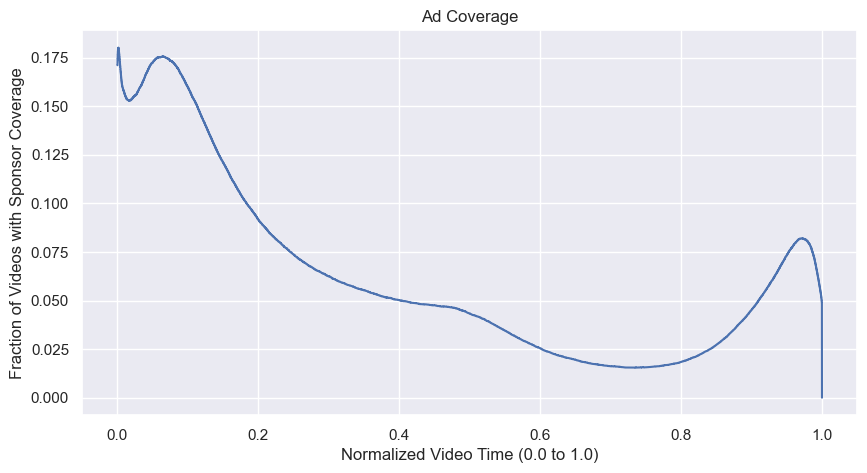

In [46]:
# Fetch coverage table into a Pandas DataFrame
df_coverage = con.sql("SELECT fraction, density FROM ad_counter").df()

# Plot with Seaborn
sns.set_theme()
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df_coverage, x="fraction", y="density",
    drawstyle="steps-post"  
)
# plt.ylim(0, 1)
plt.title("Ad Coverage")
plt.xlabel("Normalized Video Time (0.0 to 1.0)")
plt.ylabel("Fraction of Videos with Sponsor Coverage")
plt.show()


In [47]:
# I have a feeling that there is something wrong with the videos who start at 0.
# Let's get a random sample of 10 videos where the start is at zero
con.sql("select * from unique_segments where startTime = 0 ORDER BY RANDOM() LIMIT 10").show()

# Okay actually I opened like 20 videos and all of them were correct. So yeah, a lot of people actually play ads the moment the video starts, which is crazy.
# Very fun to see the steep drop in the very first few seconds, because (from opening a few videos) quite a few of them start with like "Thanks for Skillshare for Sponsoring this Video"

┌────────────┬────────────────┬─────────────┬───────────┬──────────┬───────┬────────┬────────────────┬───────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────┬─────────────────┬───────┬───────────┬────────────┬─────────┬───────────────┬────────┬────────────┬──────────────┬──────────────────────────────────────────────────────────────────┬──────────────────────────────────────────┬─────────────┐
│ ad_segment │ new_ad_segment │   videoID   │ startTime │ endTime  │ votes │ locked │ incorrectVotes │                               UUID                                │                              userID                              │  timeSubmitted  │ views │ category  │ actionType │ service │ videoDuration │ hidden │ reputation │ shadowHidden │                          hashedVideoID                           │                userAgent                 │ description │
│   double   │    boolean     │   varchar   │  d

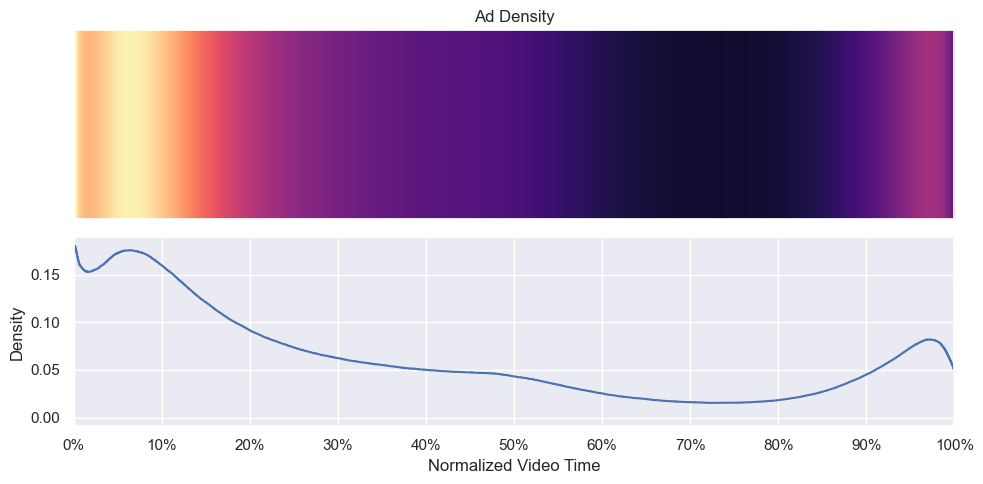

In [48]:
# Copying a heatmap + line viz from stack overflow...
# https://stackoverflow.com/questions/45841786/creating-a-1d-heat-map-from-a-line-graph
import matplotlib.ticker as mtick   

# Ensure data is sorted by fraction
df_coverage = df_coverage.sort_values("fraction")

# Extract the arrays for convenience
x = df_coverage['fraction'].values
y = df_coverage['density'].values

# Compute an approximate bin width. If there is only one point, default to 0.01.
dx = (x[1] - x[0]) if len(x) > 1 else 0.01

# Define the extent for imshow so that each "bin" is centered on its fraction.
extent = [x[0] - dx/2, x[-1] + dx/2, 0, 1]

plt.rcParams["figure.figsize"] = (10, 5)
fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True)

# Top panel: Heatmap (single-row imshow) of the coverage
ax.imshow(y[np.newaxis, :], cmap="magma", aspect="auto", extent=extent)
ax.set_yticks([])
ax.set_title("Ad Density")
ax.grid(False)
ax.set_xlim(extent[0], extent[1])

# Set ticks at every 10% on both axes (they share x-axis)
tick_positions = np.arange(0, 1.1, 0.1)  # 0%, 10%, 20%, ... 100%
ax.set_xticks(tick_positions)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Bottom panel: Step plot using Seaborn (drawstyle="steps-post" gives a piecewise-constant look)
sns.lineplot(data=df_coverage, x="fraction", y="density", 
             drawstyle="steps-post", ax=ax2)
ax2.set_xlabel("Normalized Video Time")
ax2.set_ylabel("Density")

plt.tight_layout()
plt.show()